In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Note: Ignore the file walk as there are thousands of files.
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# CNN Cancer Detection

With this notebook, we'll explore the Histopathologic Cancer Detection to identify metastatic tissue in histopathologic scans of lymph node sections. It is a modified subset of PatchCamelyon (PCam) **without** duplicates (that means later we do not need to check for duplicates). The goal of this project is to output that the center 32x32px region of a patch contains at least one pixel of tumor tissue.

# Exploratory Data Analysis (EDA)

Firstly, let's understand the data we've been given. Let's explore the labels.

In [1]:
import pandas as pd

df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Let's check - what is the distribution of the labels (i.e. count)? And are there any null values (just checking).

In [6]:
print(df['label'].value_counts())
print(df.isnull().sum())

label
0    130908
1     89117
Name: count, dtype: int64
id       0
label    0
dtype: int64


Let's visualize that distribution to see if there is any imbalance.

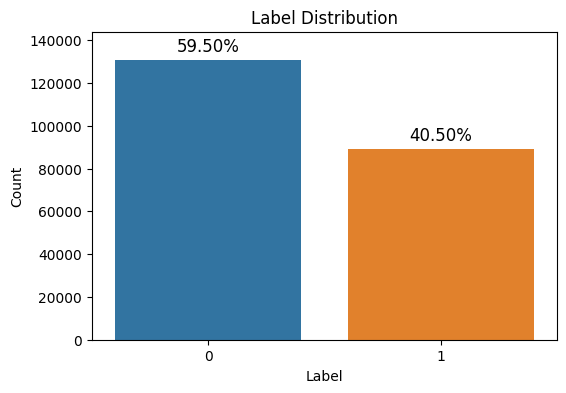

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()
total = len(df)

# Plot
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='label')

for p in ax.patches:
    count = p.get_height()
    percent = f'{100 * count / total:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + total * 0.01, percent, ha='center', va='bottom', fontsize=12)

# Format
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.ylim(0, label_counts.max() * 1.1)
plt.show()

We can see from this chart that 60% is non-cancerous and 40% is cancerous. This is a slight imbalance of data but not too much. We'll continue as-is but we may do some additional monitoring of the results (not just accuracy).

Moving on to the actual images - let's see how they look.

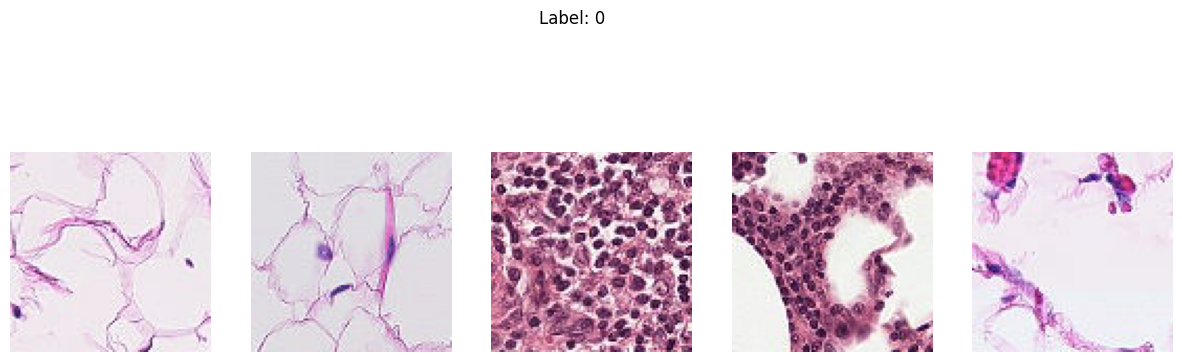

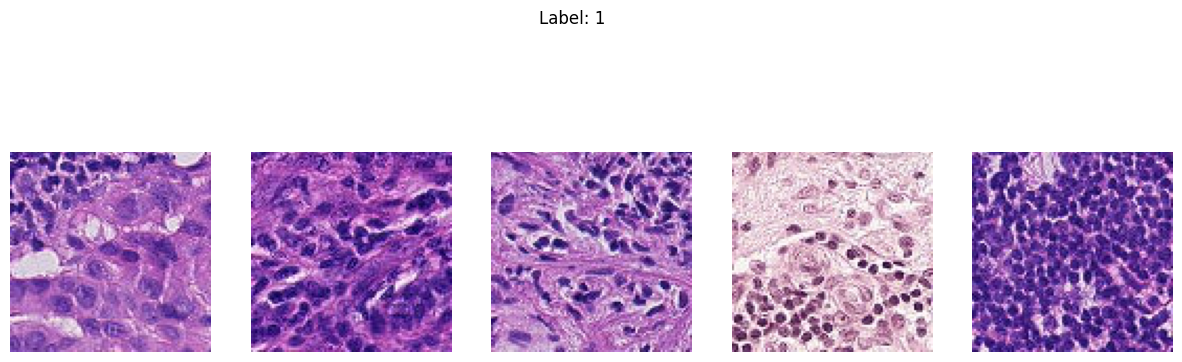

In [5]:
import cv2
import numpy as np
import os

def load_image(image_id, base_path='/kaggle/input/histopathologic-cancer-detection/train'):
    path = os.path.join(base_path, f"{image_id}.tif")
    return cv2.imread(path)

def show_samples(df, label, n=5):
    samples = df[df['label'] == label].sample(n)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for img_id, ax in zip(samples['id'], axes):
        img = load_image(img_id)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.suptitle(f"Label: {label}")
    plt.show()

show_samples(df, label=0)
show_samples(df, label=1)

From this, we see that the images are all pretty much the same size. We can get the actual size of an image by using shape. This will tell us what is the width, height, and channels (RGB).

In [6]:
img = load_image(df['id'][0])
print("Image shape:", img.shape)

Image shape: (96, 96, 3)


So, it's 96x96 pixel image with RGB (3 channels). Next we want to check the distrubition of colors of pixels in a sample image (also known as intensity). Can we see any pattern differences?

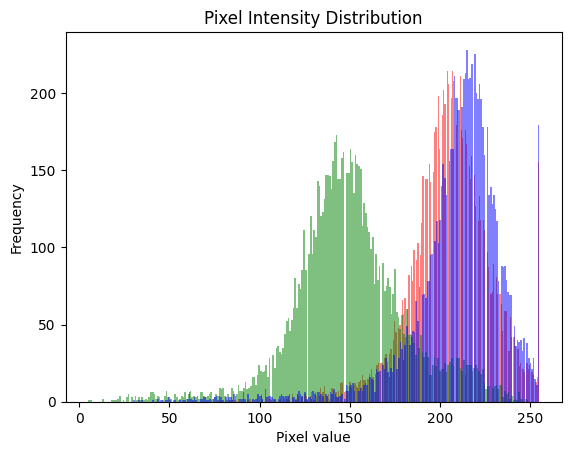

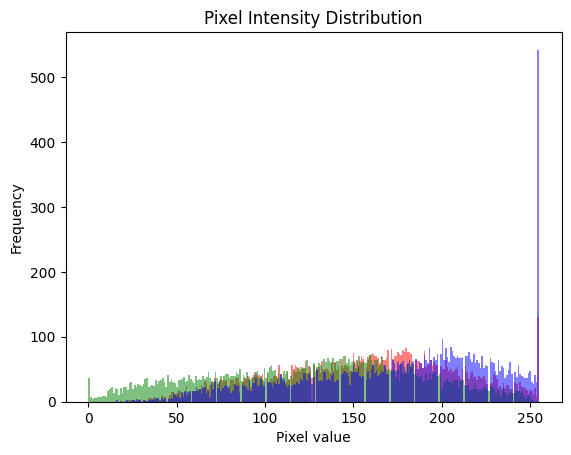

In [7]:
def plot_color_distribution_histogram(image):
    colors = ['r', 'g', 'b']
    for i, color in enumerate(colors):
        plt.hist(image[..., i].ravel(), bins=256, color=color, alpha=0.5)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel value")
    plt.ylabel("Frequency")
    plt.show()

img_tumor = load_image(df[df['label'] == 1].sample(1).iloc[0]['id'])
img_normal = load_image(df[df['label'] == 0].sample(1).iloc[0]['id'])

plot_color_distribution_histogram(img_tumor)
plot_color_distribution_histogram(img_normal)

From this, we can see that when there is cancer present, there should be deeper colors - whereas when there is not, the colors are more spread and less concentrated. But, this is only one sample so we shouldn't extrapolate too much meaning right now. Since we know there are no duplicates and no nulls, I don't need to clean the data.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


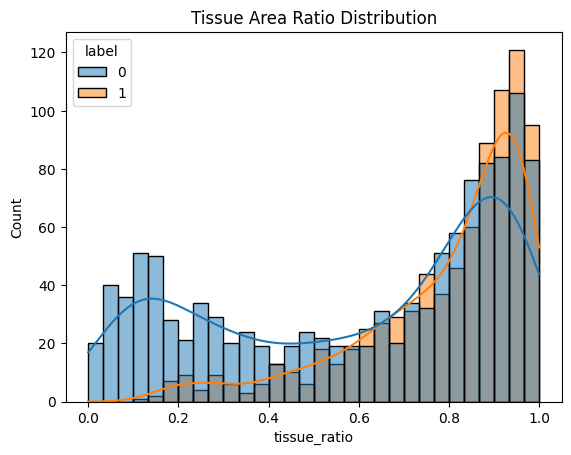

In [8]:
def tissue_ratio(img, threshold=200):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray < threshold)

# Use only a sample for EDA
sample_ids = df['id'].sample(2000, random_state=42)

ratios = sample_ids.apply(lambda id_: tissue_ratio(load_image(id_)))
df['tissue_ratio'] = ratios

sns.histplot(data=df, x='tissue_ratio', hue='label', bins=30, kde=True)
plt.title("Tissue Area Ratio Distribution")
plt.show()

We have taken a sample here of 2000 images. Looking at the tissue area, we can see that the images with cancer are more distributed to having a higher ratio for tissue whereas the images for non-cancerous tissue are spread more. This supports the previous finding from the pixel intensity graph.

**Set up for importing images**

To import the images, we need to add some additional columns such as filename (which includes the ext) and converting the label to a string (required for ImageDataGenerator).

In [2]:
df['label_str'] = df['label'].astype(str)
df['filename'] = df['id'] + '.tif'

**Split the dataset**

The last thing we want to do is split the dataset so we can do our training for the models.

In [3]:
from sklearn.model_selection import train_test_split

df_sampled, _ = train_test_split(
    df,
    train_size=40000,
    stratify=df['label'],
    random_state=42
)

train_df, val_df = train_test_split(
    df_sampled,
    test_size=0.2,                # 20% for validation
    stratify=df_sampled['label'],         # maintain class balance
    random_state=42               # reproducibility
)

print("Train label distribution:")
print(train_df['label'].value_counts(normalize=True))

print("\nValidation label distribution:")
print(val_df['label'].value_counts(normalize=True))

Train label distribution:
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64

Validation label distribution:
label
0    0.595
1    0.405
Name: proportion, dtype: float64


Now we want to sample the training set. This is because my kaggle keeps dying.

Now we will load all the images (data) and normalize them. Normalize means that we change it from 0-255 to 0-1, that's why we divide by 255.

In [4]:
import cv2
import numpy as np
import tensorflow as tf

BATCH_SIZE = 32

def load_image_cv2(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (96, 96))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.astype(np.float32) / 255.0

def data_generator(paths, labels):
    for path, label in zip(paths, labels):
        img = load_image_cv2(path)
        yield img, label

train_paths = [f"/kaggle/input/histopathologic-cancer-detection/train/{f}" for f in train_df['filename']]
train_labels = train_df['label'].values.astype(np.float32)

val_paths = [f"/kaggle/input/histopathologic-cancer-detection/train/{f}" for f in val_df['filename']]
val_labels = val_df['label'].values.astype(np.float32)

train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

I0000 00:00:1747639914.032527      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [5]:
for images, labels in val_data.take(1):
    print(np.unique(labels.numpy(), return_counts=True))

(array([0., 1.], dtype=float32), array([21, 11]))


# Model Architecture

There are two architectures that I will try with this CNN problem. The first is a basic model with a few layers and batch normalization. The second is the VGGNet that we learned about in class.

# Architecture 1: Basic Model with Batch Normalization

Here we will create a model that has only a few layers with normalization between each layer. This should be easy to train and shouldn't overfit too much with the batch normalization inbetween the layers. This follows similar to the VGGNet architecture, but without as many layers.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def build_basic(input_shape=(96, 96, 3)):
    model = models.Sequential(name="Basic_Model")
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

basic_model = build_basic()
basic_model.summary()

Model: "Basic_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 96, 96, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 147456)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         147,457 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,489 (654.25 KB)

 Trainable params: 167,169 (653.00 KB)

 Non-trainable params: 320 (1.25 KB)

# Architecture 2: VGGNet

This is following the VGGNet architecture, whereby you have multiple convolutional layers followed by a max pool layer. This is then repeated N times (for simplicity, I've repeated it only 3 times). Inside the hidden layers we will use relu and use sigmoid to output the final result. We'll use dropout to help regulate the final output an ensure no overfitting.

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_vgg_like(input_shape=(96, 96, 3)):
    model = models.Sequential(name="VGGNet")
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

vgg_model = build_vgg_like()
vgg_model.summary()

Model: "VGGNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,071,905 (19.35 MB)

 Trainable params: 5,071,905 (19.35 MB)

 Non-trainable params: 0 (0.00 B)

# Results and Analysis

Now it's time to run our models and see if we can improve them. Firstly, I'll run the model for the basic architecture. I'll then use the confusion matrix as well as the Area Under the Curve to check for the accuracy of the model.

After this, I'll run the second model (VGGNet) and perform the same evaluation.

Finally, I'll perform some hyperparameter tuning on the best model. For example, what optimizer, or loss to use.

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [22]:
basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_basic_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

steps_per_epoch = len(train_df) // BATCH_SIZE

bm_history = basic_model.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10, 
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
basic_model.evaluate(val_data)

Epoch 1/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9238 - loss: 0.1960
Epoch 1: val_accuracy improved from -inf to 0.71075, saving model to best_basic_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 51ms/step - accuracy: 0.9238 - loss: 0.1960 - val_accuracy: 0.7107 - val_loss: 1.1139 - learning_rate: 0.0010
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9435 - loss: 0.1491
Epoch 2: val_accuracy improved from 0.71075 to 0.76587, saving model to best_basic_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9435 - loss: 0.1491 - val_accuracy: 0.7659 - val_loss: 0.8378 - learning_rate: 0.0010
Epoch 3/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9608 - loss: 0.1094
Epoch 3: val_accuracy improved from 0.76587 to 0.78137, saving model to best_basic_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9608 - loss: 0.1094 - val_accuracy: 0.7814 - val_loss: 0.8892 - learning_rate: 0.0010
Epoch 4/10
 999/

[0.8377864360809326, 0.765874981880188]

Now that we've run our first model, let's plot the history for accuracy and loss.

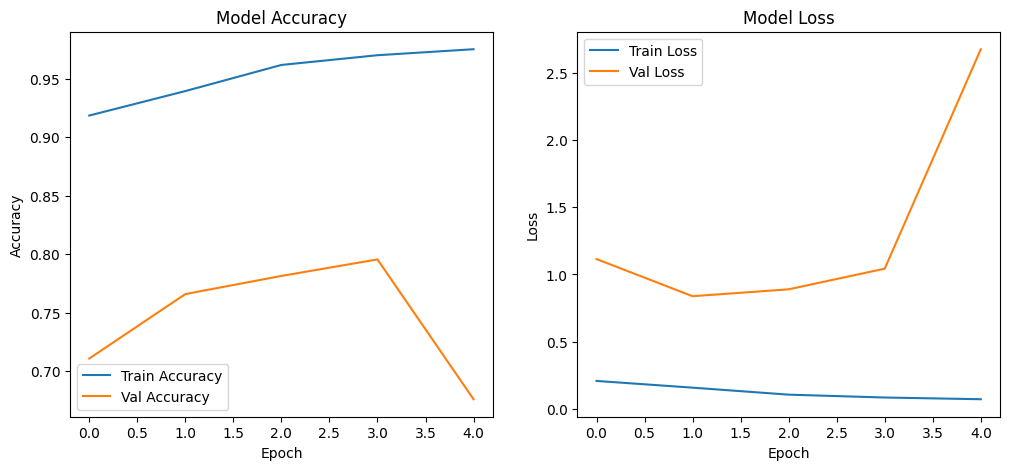

In [23]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(bm_history.history['accuracy'], label='Train Accuracy')
plt.plot(bm_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(bm_history.history['loss'], label='Train Loss')
plt.plot(bm_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
import numpy as np

# Predict on validation set
y_true_bm = []
y_pred_probs_bm = []

for batch_x, batch_y in val_data:
    preds = basic_model.predict(batch_x, verbose=0)
    y_pred_probs_bm.extend(preds.ravel())  # Flatten to 1D list
    y_true_bm.extend(batch_y.numpy().ravel())  # Convert from tensor to NumPy array

# Convert to NumPy arrays
y_true_bm = np.array(y_true_bm)
y_pred_probs_bm = np.array(y_pred_probs_bm)

# Convert probabilities to binary predictions
y_pred_bm = (y_pred_probs_bm > 0.5).astype(int)

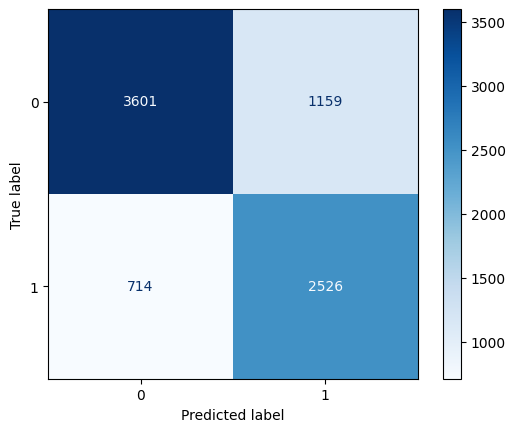

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true_bm, y_pred_bm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

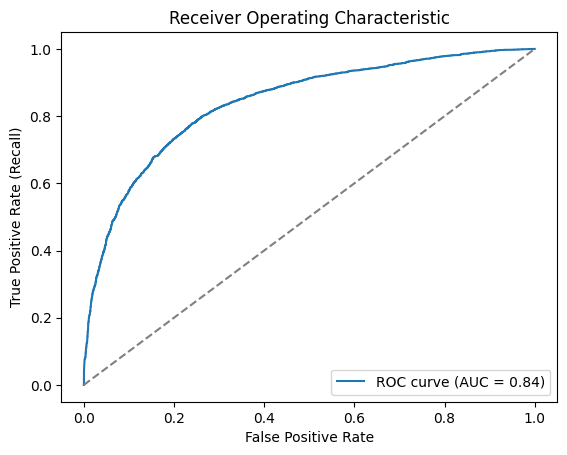

In [26]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_bm, y_pred_probs_bm)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


We need to reset the iterators for the dataset so that this model can run without problems.

In [32]:
train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [33]:
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

vgg_history = vgg_model.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
vgg_model.evaluate(val_data)

Epoch 1/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8907 - loss: 0.2619
Epoch 1: val_accuracy improved from -inf to 0.86888, saving model to best_vgg_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 72s 65ms/step - accuracy: 0.8907 - loss: 0.2619 - val_accuracy: 0.8689 - val_loss: 0.3181 - learning_rate: 0.0010
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9168 - loss: 0.2107
Epoch 2: val_accuracy did not improve from 0.86888
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - accuracy: 0.9168 - loss: 0.2107 - val_accuracy: 0.8681 - val_loss: 0.3786 - learning_rate: 0.0010
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9344 - loss: 0.1713
Epoch 3: val_accuracy did not improve from 0.86888
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.9344 - loss: 0.1713 - val_accuracy: 0.8564 - val_loss: 0.3778 - learning_rate: 0.0010
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9513 - loss: 0.1369
Epoch 4: val_accu

[0.3180886507034302, 0.8688750267028809]

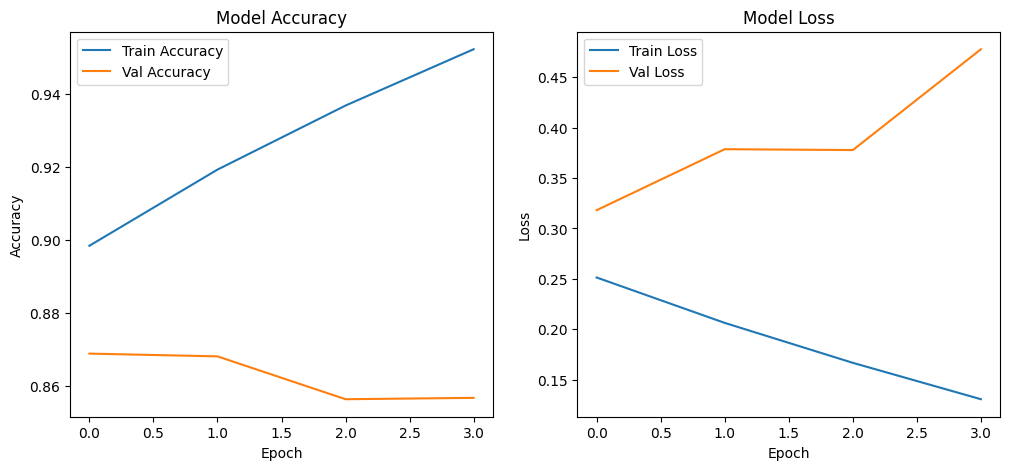

In [34]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

What I notice on this is that the training loss goes down but the validation loss goes up. This suggests overfitting on the training data. As well, the val loss goes up too high which may also suggest the learning rate is too high.

In [35]:
import numpy as np

# Predict on validation set
y_true_vgg = []
y_pred_probs_vgg = []

for batch_x, batch_y in val_data:
    preds = vgg_model.predict(batch_x, verbose=0)
    y_pred_probs_vgg.extend(preds.ravel())  # Flatten to 1D list
    y_true_vgg.extend(batch_y.numpy().ravel())  # Convert from tensor to NumPy array

# Convert to NumPy arrays
y_true_vgg = np.array(y_true_vgg)
y_pred_probs_vgg = np.array(y_pred_probs_vgg)

# Convert probabilities to binary predictions
y_pred_vgg = (y_pred_probs_vgg > 0.5).astype(int)

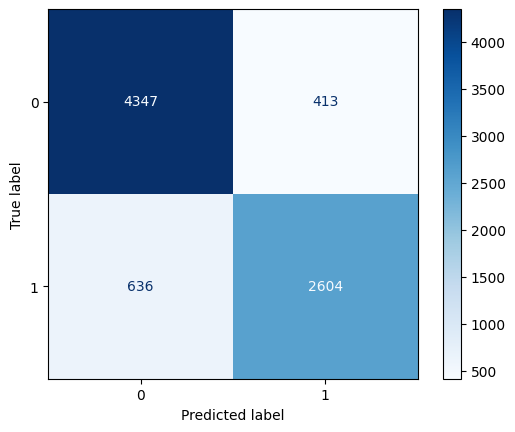

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true_vgg, y_pred_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

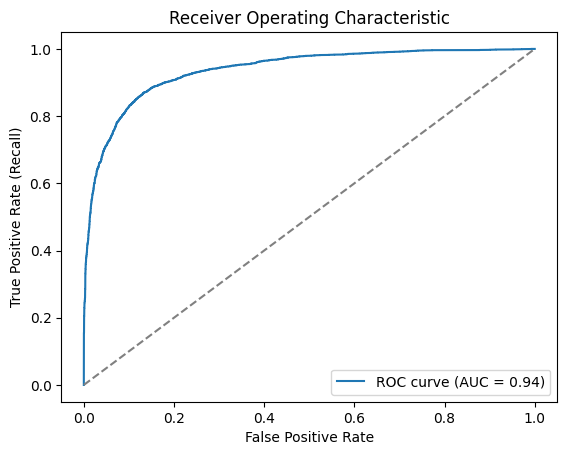

In [37]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_vgg, y_pred_probs_vgg)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Now let's do some hyperparameter tuning for the model. It's already very good, but considering this is medical data we want to avoid the false negatives and minimize that.

Firstly, we want to tune for the learning rate. The default is 1e-3, so we'll take it down to 1e-4.

This block of code is to reset the iterators.

In [41]:
train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [42]:
new_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg_model.compile(optimizer=new_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

vgg_history_v2 = vgg_model.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
vgg_model.evaluate(val_data)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9566 - loss: 0.1226
Epoch 1: val_accuracy improved from -inf to 0.87450, saving model to best_vgg_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 64ms/step - accuracy: 0.9566 - loss: 0.1226 - val_accuracy: 0.8745 - val_loss: 0.4043 - learning_rate: 1.0000e-04
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9627 - loss: 0.1038
Epoch 2: val_accuracy did not improve from 0.87450
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9627 - loss: 0.1038 - val_accuracy: 0.8721 - val_loss: 0.4709 - learning_rate: 1.0000e-04
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9727 - loss: 0.0833
Epoch 3: val_accuracy did not improve from 0.87450
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9727 - loss: 0.0832 - val_accuracy: 0.8677 - val_loss: 0.5387 - learning_rate: 1.0000e-04
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9807 - loss: 0.0635
Epoch

[0.4042523205280304, 0.8744999766349792]

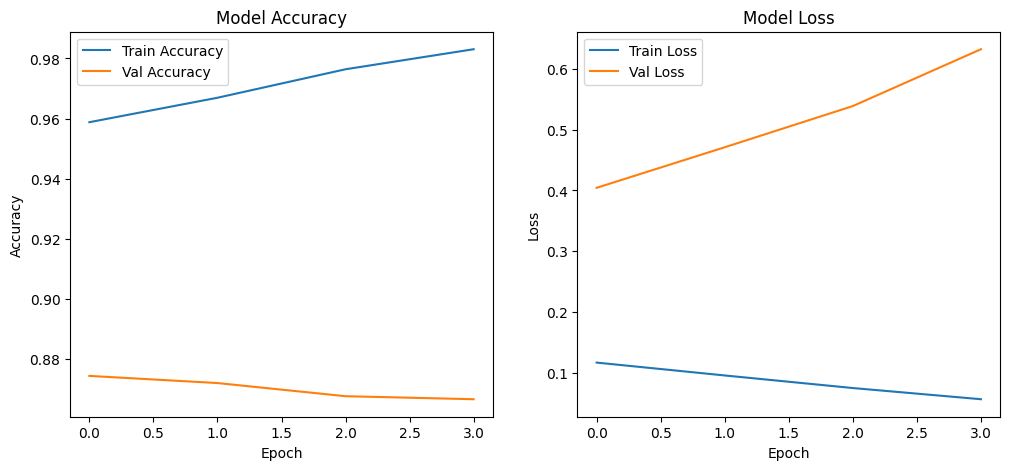

In [43]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history_v2.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history_v2.history['loss'], label='Train Loss')
plt.plot(vgg_history_v2.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

We can see that the val loss is still going up while the train loss is still going down. This suggest potential overfitting. So, I'll adapt the model to add a dropout layer.

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_vgg_like_v2(input_shape=(96, 96, 3)):
    model = models.Sequential(name="VGGNetv2")
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

vgg_model_v2 = build_vgg_like_v2()
vgg_model_v2.summary()

Model: "VGGNetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,071,905 (19.35 MB)

 Trainable params: 5,071,905 (19.35 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [46]:
new_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg_model_v2.compile(optimizer=new_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model_v2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

vgg_history_v3 = vgg_model_v2.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
vgg_model_v2.evaluate(val_data)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7139 - loss: 0.5483
Epoch 1: val_accuracy improved from -inf to 0.79150, saving model to best_vgg_model_v2.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.7139 - loss: 0.5482 - val_accuracy: 0.7915 - val_loss: 0.4538 - learning_rate: 1.0000e-04
Epoch 2/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8009 - loss: 0.4453
Epoch 2: val_accuracy improved from 0.79150 to 0.82363, saving model to best_vgg_model_v2.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.8009 - loss: 0.4453 - val_accuracy: 0.8236 - val_loss: 0.4031 - learning_rate: 1.0000e-04
Epoch 3/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8173 - loss: 0.4123
Epoch 3: val_accuracy improved from 0.82363 to 0.84588, saving model to best_vgg_model_v2.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.8173 - loss: 0.4123 - val_accuracy: 0.8459 - val_loss: 0.3642 - learning_rate: 1.0000e-04
E

[0.2832103967666626, 0.8840000033378601]

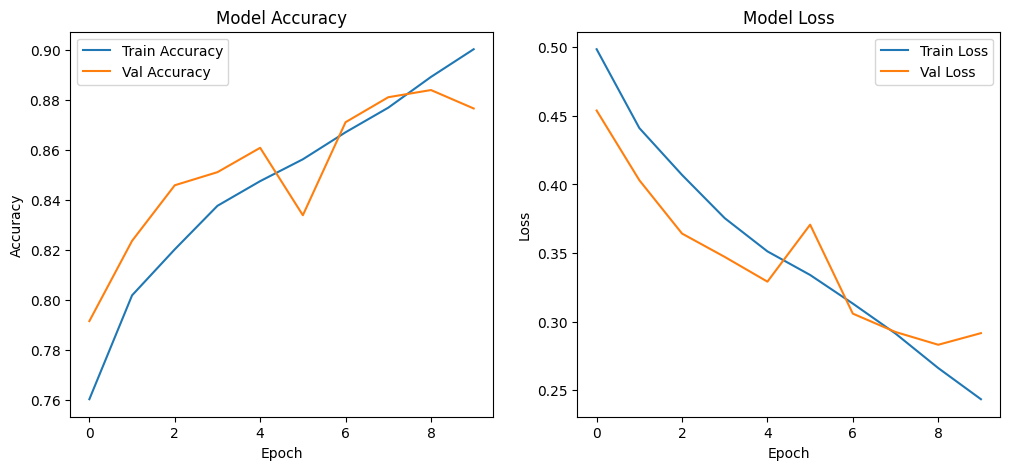

In [47]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history_v3.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history_v3.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history_v3.history['loss'], label='Train Loss')
plt.plot(vgg_history_v3.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Finally, it looks like we're on the right track. The accuracy for both val and train are heading upwards and the model loss both for are heading downwards. For my final tuning, what I want to do is add some l2 regularization to the final dense layers.

In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_vgg_like_v3(input_shape=(96, 96, 3)):
    model = models.Sequential(name="VGGNetv3")
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

vgg_model_v3 = build_vgg_like_v3()
vgg_model_v3.summary()

Model: "VGGNetv3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,071,905 (19.35 MB)

 Trainable params: 5,071,905 (19.35 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [55]:
new_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg_model_v3.compile(optimizer=new_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model_v3.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

vgg_history_v4 = vgg_model_v3.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
vgg_model_v3.evaluate(val_data)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8918 - loss: 0.2785
Epoch 1: val_accuracy improved from -inf to 0.90263, saving model to best_vgg_model_v3.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 85s 77ms/step - accuracy: 0.8918 - loss: 0.2785 - val_accuracy: 0.9026 - val_loss: 0.2612 - learning_rate: 1.0000e-04
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9028 - loss: 0.2594
Epoch 2: val_accuracy did not improve from 0.90263
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.9028 - loss: 0.2594 - val_accuracy: 0.8949 - val_loss: 0.2785 - learning_rate: 1.0000e-04
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9037 - loss: 0.2568
Epoch 3: val_accuracy improved from 0.90263 to 0.90763, saving model to best_vgg_model_v3.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.9037 - loss: 0.2568 - val_accuracy: 0.9076 - val_loss: 0.2505 - learning_rate: 1.0000e-04
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[0.22152040898799896, 0.9197499752044678]

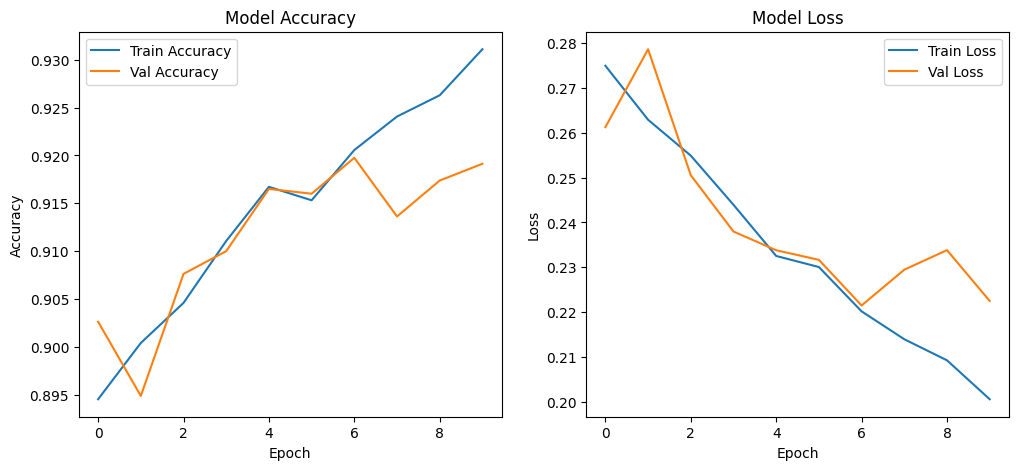

In [56]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history_v4.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history_v4.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history_v4.history['loss'], label='Train Loss')
plt.plot(vgg_history_v4.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Here we can see again that the val accuracy goes up as the train accuracy goes up and the same for the loss. This shows that the final tuning we did worked neatly.

In [57]:
import numpy as np

# Predict on validation set
y_true_vgg = []
y_pred_probs_vgg = []

for batch_x, batch_y in val_data:
    preds = vgg_model_v3.predict(batch_x, verbose=0)
    y_pred_probs_vgg.extend(preds.ravel())  # Flatten to 1D list
    y_true_vgg.extend(batch_y.numpy().ravel())  # Convert from tensor to NumPy array

# Convert to NumPy arrays
y_true_vgg = np.array(y_true_vgg)
y_pred_probs_vgg = np.array(y_pred_probs_vgg)

# Convert probabilities to binary predictions
y_pred_vgg = (y_pred_probs_vgg > 0.5).astype(int)

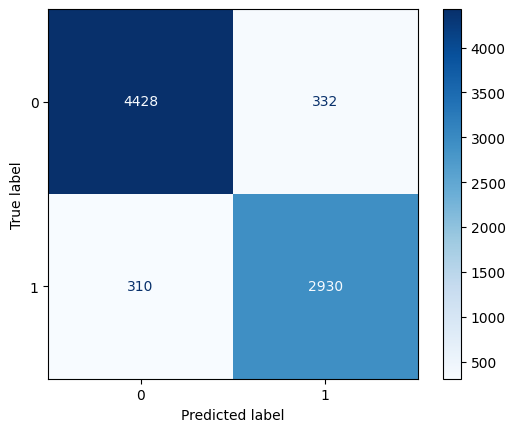

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true_vgg, y_pred_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

We have reduced the false negatives, but there are still some which means this wouldn't neccessarily be good for medical purposes.

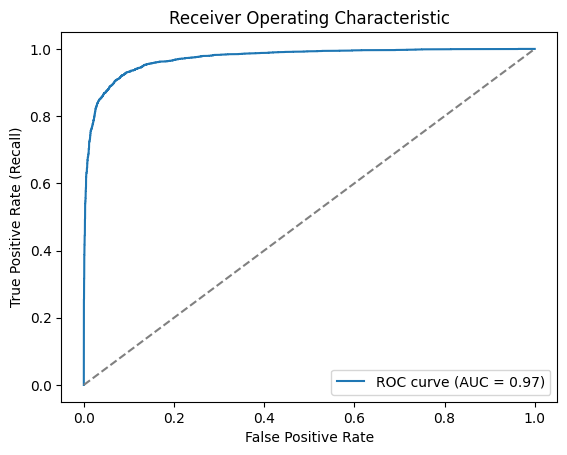

In [59]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_vgg, y_pred_probs_vgg)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

The area under the curve is at 0.97 which is really great! So our model has improved through tuning from AUC 0.94 to AUC 0.97.

In [6]:
import os
import pandas as pd

# Get all .tif filenames from the test folder
test_dir = "/kaggle/input/histopathologic-cancer-detection/test/"
test_filenames = sorted([f for f in os.listdir(test_dir) if f.endswith(".tif")])

# Extract IDs by removing ".tif"
test_ids = [f[:-4] for f in test_filenames]

In [7]:
import tensorflow as tf
import cv2
import numpy as np

def test_data_generator(paths):
    for path in paths:
        img = load_image_cv2(path)
        yield img

# Create full paths
test_paths = [os.path.join(test_dir, fname) for fname in test_filenames]

# Create tf.data.Dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_data_generator(test_paths),
    output_signature=tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32)
).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('best_vgg_model_v3.keras')

pred_probs = best_model.predict(test_dataset, verbose=1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

I0000 00:00:1747639934.351115      83 service.cc:148] XLA service 0x7879c8024fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747639934.351954      83 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747639934.481430      83 cuda_dnn.cc:529] Loaded cuDNN version 90300


      1/Unknown 2s 2s/step

I0000 00:00:1747639935.961530      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    168/Unknown 36s 205ms/step

In [ ]:
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': pred_labels
})

submission_df.to_csv("submission.csv", index=False)

# Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?